In [1]:
import duckdb
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import requests

In [2]:
## General Bikeshare Feed Specification Standard
# gbfs = requests.get('https://gbfs.mex.lyftbikes.com/gbfs/gbfs.json').json()
gbfs = requests.get('https://gbfs.mex.lyftbikes.com/gbfs/en/station_information.json').json()

## Get the Stations Information
# stations_url =  gbfs['data']['es']['feeds'][0]['url']
stations_list =  gbfs['data']['stations']

In [3]:
listOfStations = pd.DataFrame(stations_list)

## List Of Stations SImplified
stations_simplified = listOfStations[['short_name','lat','lon']]

## List Of Stations Names
stations_names = listOfStations[['short_name','name']]


In [5]:
monthName = '2025_02'
fileFolder = '/Volumes/T7 Shield/Ecobici/CLEAN'

# testDataset = duckdb.sql(f""" 
# SELECT * FROM read_parquet(['{fileFolder}/2025_01.parquet'])
# """)

rides_all = duckdb.sql(f""" 
SELECT * EXCLUDE(fecha_retiro,fecha_arribo),fecha_retiro_completa::date AS fecha_retiro,fecha_arribo_completa::date AS fecha_arribo   
    FROM read_parquet(['{fileFolder}/2025/*.parquet',
    '{fileFolder}/2024/*.parquet',
    '{fileFolder}/2023/*.parquet',
    '{fileFolder}/2022/*.parquet',
    '{fileFolder}/2021/*.parquet',
    '{fileFolder}/2020/*.parquet',
    '{fileFolder}/2019/*.parquet',
    '{fileFolder}/2018/*.parquet',
    '{fileFolder}/2017/*.parquet']) 
""")

rides_24 = duckdb.sql(f""" 
SELECT * EXCLUDE(fecha_retiro,fecha_arribo),fecha_retiro_completa::date AS fecha_retiro,fecha_arribo_completa::date AS fecha_arribo   
    FROM read_parquet([
    '{fileFolder}/2025/*.parquet',
    '{fileFolder}/2024/*.parquet'
]) 
""")

In [80]:
duckdb.sql(f""" 
SELECT date_trunc('month', fecha_arribo_completa)::date as first_day_of_month,
           date_trunc('hour', fecha_arribo_completa)::TIME::STRING as hora_arribo_summary,
           genero_usuario,edad_usuario,
           ROUND(SUM(time_between_trips)::DOUBLE,2) as trip_time,
           ROUND(SUM(distance_meters)::DOUBLE,2) as distance_meters,COUNT(*) AS total_trips
           FROM rides_24
           GROUP BY 1,2,3,4
""")

┌────────────────────┬─────────────────────┬────────────────┬──────────────┬───────────┬─────────────────┬─────────────┐
│ first_day_of_month │ hora_arribo_summary │ genero_usuario │ edad_usuario │ trip_time │ distance_meters │ total_trips │
│        date        │       varchar       │    varchar     │    int64     │  double   │     double      │    int64    │
├────────────────────┼─────────────────────┼────────────────┼──────────────┼───────────┼─────────────────┼─────────────┤
│ 2024-01-01         │ 00:00:00            │ M              │           34 │   3896.33 │        480445.1 │         244 │
│ 2024-01-01         │ 00:00:00            │ F              │           20 │    516.22 │        62479.13 │          28 │
│ 2024-01-01         │ 00:00:00            │ M              │           29 │   5841.38 │        807601.7 │         378 │
│ 2024-01-01         │ 00:00:00            │ F              │           69 │    176.73 │         5233.12 │           4 │
│ 2024-01-01         │ 00:00:00 

In [81]:
summary_data = duckdb.sql("""
SELECT date_trunc('month', fecha_arribo_completa)::date as first_day_of_month,
           date_trunc('hour', fecha_arribo_completa)::TIME::STRING as hora_arribo_summary,
           genero_usuario,edad_usuario,
           ROUND(SUM(time_between_trips)::DOUBLE,2) as trip_time,
           ROUND(SUM(distance_meters)::DOUBLE,2) as distance_meters,COUNT(*) AS total_trips
           FROM rides_24
           GROUP BY 1,2,3,4
""").df()

In [89]:
### Get the top Metrics Trips
query = """SELECT fecha_arribo,date_trunc('month', fecha_arribo_completa)::date as first_day_of_month,
        date_trunc('hour', fecha_arribo_completa)::TIME::STRING as hora_arribo_summary,
           ROUND(SUM(time_between_trips)::DOUBLE,2) as trip_time,
           ROUND(SUM(distance_meters)::DOUBLE,2) as distance_meters,COUNT(*) AS total_trips
           FROM rides_24
           GROUP BY 1,2,3"""

print(duckdb.sql(f"SELECT COUNT(*) as total_rows FROM ({query})"))

daily_rides = duckdb.sql(query).df()

┌────────────┐
│ total_rows │
│   int64    │
├────────────┤
│       8560 │
└────────────┘



In [44]:
duckdb.sql("""
           SELECT date_trunc('month', fecha_arribo)::date as first_day_of_month,
           ROUND(SUM(time_between_trips)::DOUBLE,2) as time_between_trips,
           ROUND(SUM(distance_meters)::DOUBLE,2) as distance_meters,
           SUM(total_trips) AS total_trips
           FROM daily_rides
           GROUP BY 1
           """)

┌────────────────────┬────────────────────┬─────────────────┬─────────────┐
│ first_day_of_month │ time_between_trips │ distance_meters │ total_trips │
│        date        │       double       │     double      │   int128    │
├────────────────────┼────────────────────┼─────────────────┼─────────────┤
│ 2024-10-01         │         31492557.5 │   3937050912.64 │       78065 │
│ 2024-09-01         │        28407550.21 │    3525627652.4 │       73909 │
│ 2024-06-01         │        28704284.72 │   3617285140.17 │       73986 │
│ 2024-04-01         │        30277723.63 │   3819211113.94 │       74998 │
│ 2024-03-01         │        28892704.47 │   3522984422.49 │       76779 │
│ 2024-08-01         │        28609234.79 │   3585027752.05 │       76348 │
│ 2024-11-01         │        29481988.89 │   3680586443.86 │       80768 │
│ 2024-05-01         │        14697046.36 │   1861343297.12 │       37474 │
│ 2025-01-01         │        27132077.21 │   3424545404.28 │       86391 │
│ 2024-07-01

In [86]:
nameOfTable = 'fact_trips'
tabletoexport = duckdb.sql(f""" 
SELECT date_trunc('month', fecha_arribo_completa)::date as first_day_of_month,
           date_trunc('hour', fecha_arribo_completa)::TIME::STRING as hora_arribo_summary,
           genero_usuario,edad_usuario,
           ROUND(SUM(time_between_trips)::DOUBLE,2) as trip_time,
           ROUND(SUM(distance_meters)::DOUBLE,2) as distance_meters,COUNT(*) AS total_trips
           FROM rides_24
           GROUP BY 1,2,3,4
""").df()

with duckdb.connect('/Users/gerardomartinez/Documents/ecobici_project/ecobici/evidence_project/sources/ecobici5/routes6.duckdb') as con:
    con.execute(f"""
    DROP TABLE IF EXISTS {nameOfTable}
    """)
    
    con.execute(f"""
        CREATE TABLE {nameOfTable} AS 
        SELECT * FROM tabletoexport""")

In [90]:
nameOfTable = 'fact_trips_summary2'
tabletoexport = duckdb.sql(f""" 
SELECT fecha_arribo,date_trunc('month', fecha_arribo_completa)::date as first_day_of_month,
        date_trunc('hour', fecha_arribo_completa)::TIME::STRING as hora_arribo_summary,
           ROUND(SUM(time_between_trips)::DOUBLE,2) as trip_time,
           ROUND(SUM(distance_meters)::DOUBLE,2) as distance_meters,COUNT(*) AS total_trips
           FROM rides_24
           GROUP BY 1,2,3
""").df()

with duckdb.connect('/Users/gerardomartinez/Documents/ecobici_project/ecobici/evidence_project/sources/ecobici5/routes6.duckdb') as con:
    con.execute(f"""
    DROP TABLE IF EXISTS {nameOfTable}
    """)
    
    con.execute(f"""
        CREATE TABLE {nameOfTable} AS 
        SELECT * FROM tabletoexport""")

In [91]:
tabletoexport

,fecha_arribo,first_day_of_month,hora_arribo_summary,trip_time,distance_meters,total_trips
0,2024-02-01,2024-02-01,05:00:00,2766.33,492799.95,293
1,2024-02-02,2024-02-01,11:00:00,35223.52,4321647.54,2503
2,2024-02-03,2024-02-01,04:00:00,587.95,3292.75,1
3,2024-02-03,2024-02-01,08:00:00,17348.50,2526488.89,1440
4,2024-02-05,2024-02-01,08:00:00,11231.68,1530212.23,947
...,...,...,...,...,...,...
8555,2024-12-28,2024-12-01,17:00:00,39881.00,4370758.84,2481
8556,2024-12-29,2024-12-01,02:00:00,209.38,4173.03,2
8557,2024-12-30,2024-12-01,14:00:00,49721.45,5361007.58,3297
8558,2024-12-31,2024-12-01,16:00:00,44295.60,4702861.25,2729


In [85]:
duckdb.sql(f"""
SELECT date_trunc('month', fecha_arribo)::date as first_day_of_month, 
           SUM(total_trips) AS total_trips
           FROM (SELECT fecha_arribo, hora_arribo_summary,
           genero_usuario,edad_usuario,
           ROUND(SUM(time_between_trips)::DOUBLE,2) as time_between_trips,
           ROUND(SUM(distance_meters)::DOUBLE,2) as distance_meters,COUNT(*) AS total_trips
           FROM summary_data
           GROUP BY 1,2,3,4)
           GROUP BY 1
           """)

BinderException: Binder Error: Referenced column "fecha_arribo" not found in FROM clause!
Candidate bindings: "edad_usuario", "hora_arribo_summary", "total_trips", "genero_usuario", "distance_meters"

In [133]:
with duckdb.connect('/Users/gerardomartinez/Documents/ecobici_project/ecobici/evidence_project/sources/ecobici_routes/routes4.duckdb') as con:
    con.execute("""
        DROP TABLE IF EXISTS popular_routes
    """)
    con.execute(f"""
        CREATE TABLE popular_routes AS 
        
        WITH ride_or_die AS (SELECT * EXCLUDE(fecha_retiro,fecha_arribo),fecha_retiro_completa::date AS fecha_retiro,fecha_arribo_completa::date AS fecha_arribo 
        FROM read_parquet(['{fileFolder}/2025/*.parquet'])),
        
        popular_routes as (SELECT 
        fecha_arribo,
        ciclo_estacion_retiro,
        ciclo_estacionarribo,
        ciclo_estacion_retiro || ' <-> ' || ciclo_estacionarribo AS route,                   
              date_trunc('month', fecha_arribo)::date as first_day_of_month,
       time_between_trips,distance_meters
    FROM ride_or_die)
           
       SELECT 
              fecha_arribo, first_day_of_month,
              ciclo_estacion_retiro, ciclo_estacionarribo,route,
              sn.name as station_name_retiro, sn2.name as station_name_arribo,
              COUNT(*) as total_trips,
              ROUND(SUM(distance_meters::NUMERIC),2) as total_distance_meters,
              ROUND(SUM(time_between_trips::NUMERIC),2) as total_time_between_trips
           FROM popular_routes as pr
           LEFT JOIN stations_names as sn ON sn.short_name = pr.ciclo_estacion_retiro
           LEFT JOIN stations_names as sn2 ON sn2.short_name = pr.ciclo_estacionarribo
           GROUP BY 1,2,3,4,5,6,7
           ORDER BY 1,8 DESC
    """)

# duckdb.sql("""
# WITH popular_routes as (SELECT 
#         fecha_arribo,
#         ciclo_estacion_retiro,
#         ciclo_estacionarribo,
#         ciclo_estacion_retiro || ' <-> ' || ciclo_estacionarribo AS route,                   
#               date_trunc('month', fecha_arribo)::date as first_day_of_month,
#        time_between_trips,distance_meters
#     FROM rides_24)
           
#        SELECT COUNT(*) FROM (SELECT 
#               fecha_arribo, first_day_of_month,
#               ciclo_estacion_retiro, ciclo_estacionarribo,route,
#               sn.name as station_name_retiro, sn2.name as station_name_arribo,
#               COUNT(*) as total_trips,
#               ROUND(SUM(distance_meters::NUMERIC),2) as total_distance_meters,
#               ROUND(SUM(time_between_trips::NUMERIC),2) as total_time_between_trips
#            FROM popular_routes as pr
#            LEFT JOIN stations_names as sn ON sn.short_name = pr.ciclo_estacion_retiro
#            LEFT JOIN stations_names as sn2 ON sn2.short_name = pr.ciclo_estacionarribo
#            GROUP BY 1,2,3,4,5,6,7
#            ORDER BY 1,8 DESC)
#     """)

In [76]:
simple_day = duckdb.sql(f""" 
SELECT * EXCLUDE(fecha_retiro,fecha_arribo),fecha_retiro_completa::date AS fecha_retiro,fecha_arribo_completa::date AS fecha_arribo  FROM read_parquet(['{fileFolder}/2025/*.parquet']) LIMIT 10
""")

┌────────────────┬──────────────┬─────────┬───────────────────────┬─────────────────────┬──────────────────────┬─────────────────────┬───────────────────────┬───────────────────────┬────────────────────┬─────────────────┬────────────┬───────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬──────────────┬──────────────┐
│ genero_usuario │ edad_usuario │  bici   │ ciclo_estacion_retiro │     hora_retiro     │ ciclo_estacionarribo │     hora_arribo     │ fecha_retiro_completa │ fecha_arribo_completa │ time_between_trips │ day_of_the_week │ is_weekend │     lat_start     │     lon_start      │      lat_end       │      lon_end       │  distance_meters   │ fecha_retiro │ fecha_arribo │
│    varchar     │    int64     │ varchar │        varchar        │ time with time zone │       varchar        │ time with time zone │       timestamp       │       timestamp       │       double       │     varchar     │   int32    │      double       │       d

In [87]:
simple_day = duckdb.sql(f"""
           SELECT fecha_arribo,
              CASE 
                  WHEN genero_usuario IN ('F', 'M') THEN genero_usuario 
                  ELSE 'O' 
              END as genero_usuario,                   
              date_trunc('month', fecha_arribo)::date as first_day_of_month,
              day_of_the_week,
              is_weekend,
              COUNT(*) as total_trips
           FROM rides_24
           GROUP BY fecha_arribo, day_of_the_week, is_weekend,genero_usuario
           ORDER BY fecha_arribo DESC
""").df()

In [39]:
all_rides = duckdb.sql(f""" 
SELECT * EXCLUDE(hora_arribo,hora_retiro), hora_arribo::string as hora_arribo,hora_retiro::string as hora_retiro
FROM read_parquet(['{fileFolder}/2024/*.parquet']) 
""").df()

In [88]:
simple_day.genero_usa

,fecha_arribo,genero_usuario,first_day_of_month,day_of_the_week,is_weekend,total_trips
0,2025-01-31,O,2025-01-01,Friday,0,1194
1,2025-01-31,O,2025-01-01,Friday,0,753
2,2025-01-31,F,2025-01-01,Friday,0,18503
3,2025-01-31,M,2025-01-01,Friday,0,47766
4,2025-01-30,F,2025-01-01,Thursday,0,19991


In [89]:
# Use the DataFrame to delete the table if it exists and create it again in the new connection
with duckdb.connect('ecobici2.duckdb') as con:
    con.execute("""
        DROP TABLE IF EXISTS trips_per_day_w_gender
    """)
    con.execute("""
        CREATE TABLE trips_per_day_w_gender AS SELECT * FROM simple_day
    """)
    # con.execute("""
    #     INSERT INTO trips_per_day
    #     SELECT * FROM simple_day
    #     ON CONFLICT DO NOTHING
    # """)

In [3]:
### Trips Per Month MoM
mom_df = duckdb.sql(""" 
           WITH trips_p_month as (
           SELECT date_trunc('month', fecha_arribo)::date as months, COUNT(*) as trips_per_month
           FROM rides_24
           GROUP BY date_trunc('month', fecha_arribo)::date
           ), mom_g as (
           SELECT months, 
                  trips_per_month, 
                  LAG(trips_per_month,1) OVER(ORDER BY months) AS previous_month_trips
           FROM trips_p_month
           )
           
           SELECT *,
           ROUND((((trips_per_month - previous_month_trips) / previous_month_trips) * 100)::numeric,2) as mom_growth
           FROM mom_g 
           ORDER BY months
""").df()

mom_df['months'] = pd.to_datetime(mom_df['months'])
mom_df['time'] = np.arange(len(mom_df))

# Prepare the features and target variable
X = mom_df[['time']]
y = mom_df['trips_per_month']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Add a new column with the trend (predicted trips)
mom_df['trend'] = model.predict(X)

In [4]:
# Calculate standard deviation and mean
std_dev = mom_df['trips_per_month'].std()
mean = mom_df['trips_per_month'].mean()
median = mom_df['trips_per_month'].median()

# Add columns for +1.5 std dev and -1.5 std dev
mom_df['+1.5_std_dev'] = mean + 1 * std_dev
mom_df['-1.5_std_dev'] = mean - 1 * std_dev
mom_df['mean'] = mean
mom_df['median'] = median

# Add a column for z-index
mom_df['z_index'] = (mom_df['trips_per_month'] - mean) / std_dev

In [125]:
with duckdb.connect('/Users/gerardomartinez/Documents/ecobici_project/ecobici/evidence_project/sources/routes/routes.duckdb') as con:
    asfs = con.execute(f"""
    SELECT * FROM popular_routes
    """).fetchdf()
    print(asfs)

   count_star()
0      24779931


In [122]:
with duckdb.connect("/Users/gerardomartinez/Documents/ecobici_project/ecobici/evidence_project/sources/routes/routes.duckdb") as con:
    tables_df = con.execute("SHOW TABLES").fetchdf()
    print(tables_df)

             name
0  popular_routes


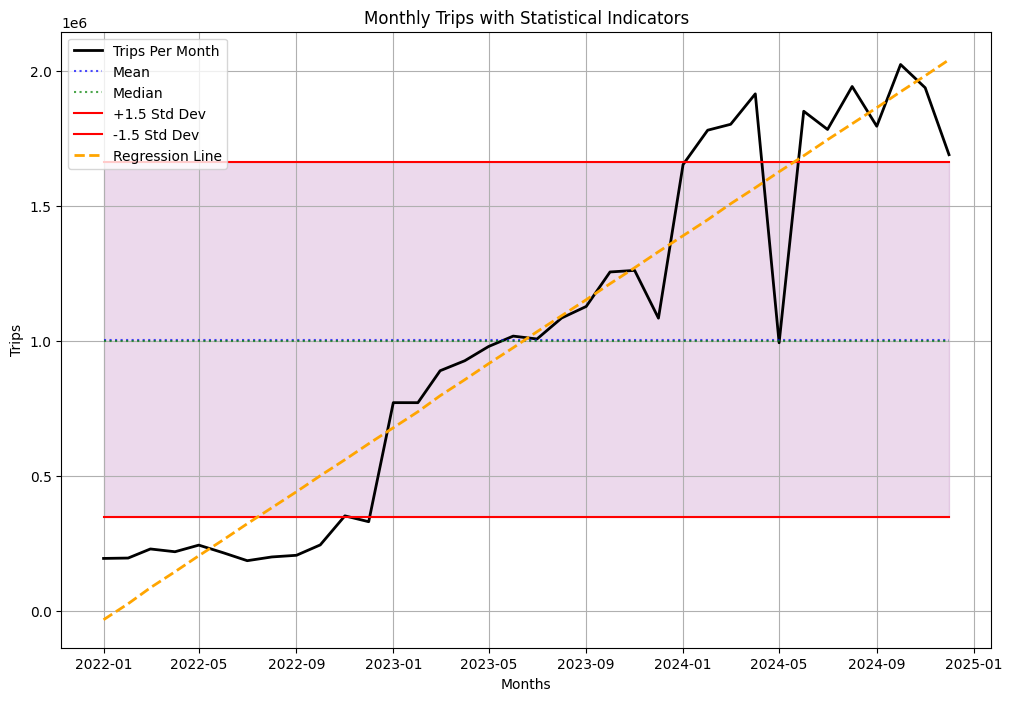

In [130]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 8))

# Plot trips per month
plt.plot(mom_df['months'], mom_df['trips_per_month'], label='Trips Per Month', color='black', linestyle='-', linewidth=2)

# Plot mean and median with dotted lines and transparency
plt.plot(mom_df['months'], mom_df['mean'], label='Mean', color='blue', linestyle=':', alpha=0.7)
plt.plot(mom_df['months'], mom_df['median'], label='Median', color='green', linestyle=':', alpha=0.7)

# Plot standard deviations with solid lines
plt.plot(mom_df['months'], mom_df['+1.5_std_dev'], label='+1.5 Std Dev', color='red', linestyle='-', linewidth=1.5)
plt.plot(mom_df['months'], mom_df['-1.5_std_dev'], label='-1.5 Std Dev', color='red', linestyle='-', linewidth=1.5)

# Plot the regression line
plt.plot(mom_df['months'], mom_df['trend'], label='Regression Line', color='orange', linestyle='--', linewidth=2)

# Fill the area between +1.5 std dev and -1.5 std dev
plt.fill_between(mom_df['months'], mom_df['+1.5_std_dev'], mom_df['-1.5_std_dev'], color='purple', alpha=0.15)

# Add labels, title, and legend
plt.xlabel('Months')
plt.ylabel('Trips')
plt.title('Monthly Trips with Statistical Indicators')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


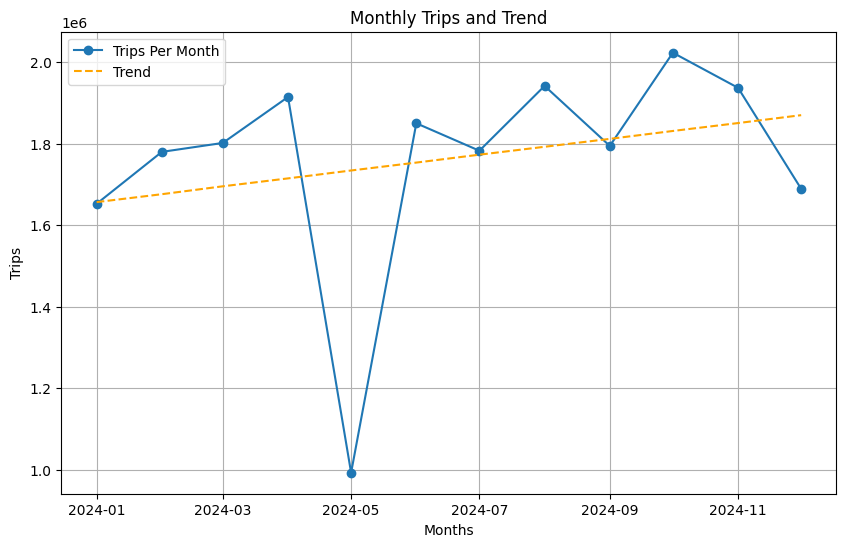

In [ ]:
import matplotlib.pyplot as plt

# Plot trips per month and trend
plt.figure(figsize=(10, 6))
plt.plot(mom_df['months'], mom_df['trips_per_month'], label='Trips Per Month', marker='o')
plt.plot(mom_df['months'], mom_df['trend'], label='Trend', linestyle='--', color='orange')

# Add labels, title, and legend
plt.xlabel('Months')
plt.ylabel('Trips')
plt.title('Monthly Trips and Trend')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# import os

# for yr in ['2017','2018','2019','2020','2021','2022','2023','2024','2025']:
#     filesO = os.listdir(f'{fileFolder}/{yr}/')
#     print(yr, end=' . ')

#     for i in filesO:
#         ah = pd.read_parquet(f'{fileFolder}/{yr}/{i}')
        
#         #  Change all column names to lowercase
#         ah.columns = ah.columns.str.lower()
#         ah.columns = ah.columns.str.replace(' ', '_')

#         # Convert 'fecha_retiro' column to date
#         ah['fecha_retiro'] = pd.to_datetime(ah['fecha_retiro'], format='mixed')
#         ah['fecha_arribo'] = pd.to_datetime(ah['fecha_arribo'], format='mixed')
#         ah['hora_retiro'] = pd.to_datetime(ah['hora_retiro'], format='%H:%M:%S').dt.time
#         ah['hora_arribo'] = pd.to_datetime(ah['hora_arribo'], format='%H:%M:%S').dt.time

#         ah.to_parquet(f'{fileFolder}/{yr}/{i}')


2017 . 2018 . 2019 . 2020 . 2021 . 2022 . 2023 . 2024 . 2025 . 

In [ ]:
duckdb.sql("""
WITH bici_p_month as (
        SELECT  bici, COUNT(DISTINCT EXTRACT(MONTH FROM fecha_arribo)) as months_in_use
        FROM rides_24
        GROUP BY bici)

    SELECT r24.bici, bp.months_in_use ,COUNT(*) as trips
    FROM rides_24 as r24
    LEFT JOIN bici_p_month as bp ON r24.bici = bp.bici
    GROUP BY r24.bici, bp.months_in_use
""")

┌─────────┬───────────────┬───────┐
│  bici   │ months_in_use │ trips │
│  int64  │     int64     │ int64 │
├─────────┼───────────────┼───────┤
│ 6168397 │            12 │  2688 │
│ 3215845 │            12 │  2304 │
│ 7181779 │            12 │  2340 │
│ 5426200 │            12 │  2157 │
│ 5283098 │            12 │  2388 │
│ 3668472 │            12 │  2030 │
│ 4703534 │            12 │  2262 │
│ 5568571 │            12 │  2734 │
│ 4499737 │            12 │  2644 │
│ 6451306 │            12 │  2701 │
│    ·    │             · │    ·  │
│    ·    │             · │    ·  │
│    ·    │             · │    ·  │
│ 5844030 │            12 │   501 │
│ 6914758 │            12 │   137 │
│ 4361895 │            12 │   559 │
│ 4762548 │            12 │   476 │
│ 8159444 │            12 │  2303 │
│ 3018512 │            12 │   500 │
│ 7818594 │            12 │   439 │
│ 2956167 │             7 │    26 │
│ 7604226 │            10 │   139 │
│ 2308419 │            12 │   756 │
├─────────┴───────────────┴─